In [1]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import scipy as scp
from scipy import sparse

NUM_SAMPLES = 200
SMALL_VAL = -100000000
ITER_THRESH = 5

In [2]:
#A function to get the 20 newsgroup data
def get_data():
    #news_groups_all = fetch_20newsgroups(subset='all')
    #news_data = news_groups_all.data

    #Load in the vectorized news group data from scikit-learn package
    news = fetch_20newsgroups(subset='all')
    all_data = np.array(news.data)
    all_targets = np.array(news.target)
    class_names = news.target_names

    #Set class pairings as described in the multiview clustering paper
    view1_classes = ['comp.graphics','rec.motorcycles', 'sci.space', 'rec.sport.hockey', 'comp.sys.ibm.pc.hardware']
    view2_classes = ['rec.autos', 'sci.med','misc.forsale', 'soc.religion.christian','comp.os.ms-windows.misc']
    
    #Create lists to hold data and labels for each of the 5 classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(NUM_SAMPLES)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample 200 items from each of the selected classes in view1
    for ind in range(len(view1_classes)):
        class_num = class_names.index(view1_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
   
        
    #Randomly sample 200 items from each of the selected classes in view2
    for ind in range(len(view2_classes)):
        class_num = class_names.index(view2_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view2_data.append(class_data[indices])  
    view2_data = np.concatenate(view2_data)
    
    #Vectorize the data
    vectorizer = CountVectorizer()
    view1_data = vectorizer.fit_transform(view1_data)
    view2_data = vectorizer.fit_transform(view2_data)

    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(NUM_SAMPLES * len(view1_classes))
    view1_data = sparse.vstack(view1_data)
    view2_data = sparse.vstack(view2_data)
    view1_data = np.array(view1_data[shuffled_inds].todense())
    view2_data = np.array(view2_data[shuffled_inds].todense())
    labels = labels[shuffled_inds]

    return view1_data, view2_data, labels


In [3]:
v1_data, v2_data, labels = get_data()

In [4]:
def log_sum_exp(log_likes):
    a_vals =  np.max(log_likes, axis = 0)
    likes = np.exp(log_likes - a_vals)
    log_sum = a_vals + np.log(np.sum(likes, axis = 0))
    return log_sum
    
def compute_posterior(data, w_probs, alphas, k):
    log_likes = list()
    for ind in range(k):
        #Compute the likelihood
        log_like = np.sum(data * np.log(w_probs[ind]), axis = 1)
        log_likes.append(log_like)  
    log_likes = np.vstack(log_likes)
    log_prior = np.log(alphas).reshape(-1, 1)
    #log_prior = np.log(np.array([0.2, 0.2, 0.2, 0.2, 0.2])).reshape(-1,1)
    numer = log_prior + log_likes
    denoms = log_sum_exp(numer)
    log_post = numer - denoms
    
    #Compute the denominator of posterior
    posterior = np.exp(log_post)
    log_likes = np.sum(denoms)
    
    return posterior, log_likes

def compute_posterior2(data, w_probs, alphas, k):
    likes = list()
    for ind in range(k):
        like = data * w_probs[ind]
        like = np.sum(like, axis=1)
        likes.append(like)  
    likes = np.vstack(likes)
    likes_p = likes * alphas.reshape((-1, 1))
    likes_sum = np.sum(likes_p, axis=1).reshape((-1, 1))
    likes_sum[likes_sum == 0] = 1
    posterior = likes_p / likes_sum
    log_like = np.sum(np.log2(likes_sum))
    return posterior, log_like

def iterate(data, posteriors, k):
    
    #For each of the mixture components, compute model params
    w_probs = list()
    for ind in range(k):
        numer = data * posteriors[ind].reshape((-1, 1))
        numer = 1 + np.sum(numer, axis=0)
        denom = np.sum(numer)
        if(denom == 0):
            denom = 1
        probs = numer/denom
        w_probs.append(probs)
    w_probs = np.vstack(w_probs)
    alphas = np.mean(posteriors, axis=1)
    
    #Compute new posterior
    new_posteriors, log_like = compute_posterior(data, w_probs, alphas, k)
    return w_probs, alphas, new_posteriors, log_like

def final_clusters(posteriors):
    metric = posteriors[0] + posteriors[1]
    f_clusters = np.argmax(metric, axis = 0)
    return f_clusters

def compute_entropy(partitions, labels, k, num_classes):
    
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        if(labs.shape[0] == 0):
            continue
        part_size = labs.shape[0]
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / part_size
            ent = 0
            if(prop != 0):
                ent = - prop * np.log2(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy
    

In [5]:
#The main kmeans clustering algorithm
def multinomial(v_data, labels, k = 5):

    #Initialize cluster centers, partitions, and loop params
    w_probs2 = np.random.random((k, v_data[1].shape[1]))
    #w_probs2 = v_data[1][np.random.choice(v_data[1].shape[0], k)]
    w_probs2 = w_probs2/ np.sum(w_probs2, axis=1).reshape((-1, 1))
    w_probs = [None, w_probs2]                              
    alphas2 = (1/k) * np.ones((k,))
    alphas = [None, alphas2]
    
    posterior2, log_likes = compute_posterior(v_data[1], w_probs[1], alphas[1], k)
    posteriors = [None, posterior2]
    
    objective = [SMALL_VAL, SMALL_VAL]
    iter_stall = 0
    iter_num = 0
    entropy = 0
    
    while(iter_stall < ITER_THRESH):
        iter_num += 1
        view = (iter_num + 1) % 2
        
        #Switch partitions, Maximization, and Expectation
        w_probs[view], alphas[view], posteriors[view], log_like = iterate(v_data[view], posteriors[(view + 1) % 2], k)
        iter_stall += 1
        #Recompute objective function
        if(log_like > objective[view]):
            objective[view] = log_like
            iter_stall = 0
        
        clusts = np.argmax(posteriors[view], axis = 0)
        #Obtain evaluation metrics
        f_clusters = final_clusters(posteriors)
        entropy = compute_entropy(f_clusters, labels, k, 5)
        #print(entropy)

    return entropy
        

In [6]:
#The main kmeans clustering algorithm
def single_multinomial(v_data, labels, k = 5):
    
    v_data = np.concatenate(v_data, axis = 1)
    #Initialize cluster centers, partitions, and loop params
    w_probs = np.random.random((k, v_data.shape[1]))
    
    w_probs /= np.sum(w_probs, axis=1).reshape((-1, 1))    
    alphas = (1/k) * np.ones((k,))
    
    posterior, log_likes = compute_posterior(v_data, w_probs, alphas, k)
    objective = SMALL_VAL
    iter_stall = 0
    iter_num = 0
    entropy = 0
    
    while(iter_stall < ITER_THRESH):
        iter_num += 1
        view = (iter_num + 1) % 2
        
        #Switch partitions, Maximization, and Expectation
        w_probs, alphas, posterior, log_like = iterate(v_data, posterior, k)
        iter_stall += 1
        #Recompute objective function
        if(log_like > objective):
            objective = log_like
            iter_stall = 0
        
        #Obtain evaluation metrics
        f_clusters = np.argmax(posterior, axis = 0)
        entropy = compute_entropy(f_clusters, labels, k, 5)

    return entropy

In [7]:
def getEntropies(v1_data, v2_data, labels):
    
    entropies = list()
    for num in range(1,11):
        ent = multinomial([v1_data, v2_data], labels, num)
        print(ent)
        entropies.append(ent)
    return entropies

def getSingleEntropies(v1_data, v2_data, labels):
    
    entropies = list()
    for num in range(1, 11):
        ent = single_multinomial([v1_data, v2_data], labels, num)
        entropies.append(ent)
        print(ent)
    return entropies

In [8]:
#Multiview multinomial
num_trials = 1
mult_entropies = list()
for ind in range(num_trials):
    entropies = getEntropies(v1_data, v2_data, labels)
    mult_entropies.append(entropies)
mult_entropies = np.array(mult_entropies)
mult_entropies = np.mean(mult_entropies, axis=0)

#Singleview multinomial
num_trials = 1
entropies_single = list()
for ind in range(num_trials):
    entropies = getSingleEntropies(v1_data, v2_data, labels)
    entropies_single.append(entropies)
entropies_single = np.array(entropies_single)
entropies_single = np.mean(entropies_single, axis=0)

2.321928094887362
2.321928094887362
2.321928094887362
2.321928094887362
2.321928094887362
2.321928094887362
2.321928094887362
2.321928094887362
2.309382348622725
2.3022591249830207
2.287378052084809
2.2706565615517618
2.25807872507926
2.245960488661508
2.2309875804540207
2.219166526606073
2.2079557461822183
2.1900244181770754
2.1833431744445493
2.1687190397391642
2.160107965766162
2.1573679258068363
2.149688062004459
2.1476929606763484
2.144710345473273
2.143082612877891
2.137864796499521
2.1329909745697444
2.119445368377632
2.086682538162292
1.9919575336164606
1.8924539305709307
1.7953379872587933
1.7672513466128785
1.7408186963874046
1.7070253575817502
1.6792323220705416
1.6528585424702256
1.6466532270846526
1.6314506246826115
1.629680768140147
1.6201278174936953
1.6044960150634404
1.5926964782002662
1.5751664541194583
1.572082860699778
1.572082860699778
1.5685089365061662
1.5648673238668296
1.5648673238668296
1.5616668202596276
1.5616668202596276
1.554918226433024
1.554918226433024


C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


1.4840571114925887
1.4840571114925887
1.4840571114925887
2.1683008374752
2.124636767017261
2.0952883092798786
2.052215347538981
1.9835263950444433
1.8976607329878477
1.8420281468982538
1.8123065533268679
1.7840402922934135
1.766729796036728
1.7433891098710448
1.7143881449248068
1.6687980192724572
1.6543361828023726
1.6383422391431801
1.6383422391431801
1.6383422391431801
1.6332541608932027
1.6332541608932027
1.6332541608932027
1.6332541608932027
1.6332541608932027
1.6302344563212934
1.6302344563212934
1.6302344563212934
1.6302344563212934
1.6302344563212934
1.6302344563212934
1.6302344563212934
1.6302344563212934
1.6302344563212934
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
1.6314503105302465
2.232088398949415
2.1980458190431924
2.161055469411951
2

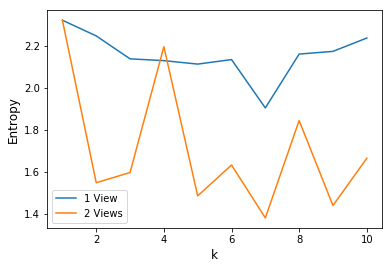

In [10]:
import matplotlib.pyplot as plt
x_values = list(range(1, 11))
plt.plot(x_values, entropies_single, x_values, mult_entropies)
plt.xlabel('k')
plt.ylabel('Entropy')
plt.legend(['1 View', '2 Views'])
plt.rc('axes', labelsize=12)
plt.show()